# Libraries

In [1]:
import csv
import os
import json
import umap
import textacy
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Articles

In [2]:
articles = []

dir = "data/biomass/"
files = os.listdir(dir)  # Set folder and files

for filename in files:

    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)

    # Parse

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Set Title

        url = data[0]["url"]  # Set URL
        if any(x in url for x in {"feeds.", "rss.", "briefing"}):
            continue  # Blacklist (Bob Dylan's case)
        # if not any(
        #     x in url
        #     for x in {
        #         "wsj.com",
        #         "usatoday.com",
        #         "nytimes.com",
        #         "latimes.com",
        #         "nypost.com",
        #         "washingtonpost.com",
        #         "chicagotribune.com",
        #         "chron.com",
        #         "nydailynews.com",
        #         "theguardian.com",
        #     }
        # ):
        #     continue  # Whitelist

        entities = data[0]["story_tags"]  # Set sentities
        if len(entities) > 100:
            continue  # Set max
        if len(entities) <= 1:
            continue  # Set min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—":
                continue  # Remove listings
            if name.startswith("geonames_"):
                continue  # Skip geotag
            if "readability" in name:
                continue  # Clean
            if "cliff_clavin_" in name:
                continue  # Clean
            if "nyt_labeller" in name:
                continue  # Clean

            name = " ".join(name.split())  # Merge multiple spaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if name.startswith("US "):
                    name = name[3:]  # Remove prefix
                if name.endswith(" Corp"):
                    name = name[:-5]  # Remive postfix
                if name.endswith(" Inc"):
                    name = name[:-4]  # Remive postfix
                if name.endswith(" LCC"):
                    name = name[:-4]  # Remive postfix
                if name[0].islower():
                    continue  # Remove lowercase
                if name[1].isupper():
                    continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name:
                    continue  # Clean
                if name[1].isupper():
                    continue  # Remove uppercase
                if name[0].islower():
                    continue  # Remove lowercase
                if len(name.split(" ")) == 1:
                    continue  # remove those with no family name
                people.append(name)

        if len(orgs) > 0 and len(subjects) > 0:
            articles.append(
                [
                    year,
                    title,
                    url,
                    list(set(subjects)),
                    list(set(orgs)),
                    list(set(people)),
                ]
            ) # Add these articles with actors only


    except:
        continue  # In case of error


articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
)  # Dataset

articles = articles.drop_duplicates(subset=["url"])  # Remove articles with the same URL

print('\n' + str(articles.shape[0]))

articles.sample(10)



18153


,year,title,url,subjects,orgs,people
1281,2020,EXMceuticals Inc. Announces Receipt Of Landmar...,https://www.thestreet.com/press-releases/exmce...,"[finances, diseases and conditions, medicine a...","[European Regional Development Fund, Universid...","[Susana Santos, Paulo Martins, Jonathan Summers]"
778,2018,"IFC extends Rs 1,000 cr green loan to Aditya B...",https://www.business-standard.com/article/pti-...,"[energy and power, finances, light, electric l...","[Aditya Birla Finance, Aditya Birla Capital, A...",[Ajay Srinivasan]
3413,2018,Project Syndicate: 3 disappointing ways China’...,http://www.marketwatch.com/news/story.asp?guid...,"[finances, economic conditions and trends, pol...","[Stanford University, 11th Central Committee, ...","[Wen Jiabao, Richard A Easterlin, Fei Wang, De..."
3069,2016,"Sunbird project to empower 200,000 farmers",https://www.daily-mail.co.zm/?p=75168,"[finances, economic conditions and trends, agr...",[Ministry of Commerce],[Edgar Lungu]
667,2014,Finding Ethical Alpha,https://www.huffpost.com/entry/finding-ethical...,"[computers and the internet, economic conditio...",[Fidelity],"[Lawrence Bloom, Edgar Kahn, Dennis Bushnell, ..."
1675,2014,North Sea still has vital role in keeping the ...,http://telegraph.feedsportal.com/c/32726/f/568...,"[energy and power, oil (petroleum) and gasolin...",[Peterhead CCS],[Ed Davey]
18793,2019,Chemesis International Inc. Receives Three Add...,http://www.globenewswire.com/news-release/2019...,"[farmers, agriculture]","[La Finca, World Bank, La Finca Interacviva-Ar...","[Ricardo Garzon, Edgar Montero]"
325,2016,Japan produces silicone prosthetics for patien...,http://www.business-standard.com/article/news-...,[medicine and health],"[University of Malaya, Ebara Corporation]","[Nakamura Brace, Seiichi Kanamori, Toshihiro N..."
15393,2019,Emerald Health Therapeutics’ Pure Sunfarms JV ...,http://www.globenewswire.com/news-release/2019...,"[corporations, company reports]","[Emerald Health Therapeutics, Delta]",[Riaz Bandali]
9292,2018,Incinerators stymie progress,https://www.irishtimes.com/opinion/letters/inc...,"[food, waste materials and disposal]","[Green Party, University of Limerick, Cork Har...","[Mary O’Leary, Eamon Ryan]"


## Entities

In [3]:
entities = np.empty((0, 12), dtype=object)

years_template = {
    2011: 0,
    2012: 0,
    2013: 0,
    2014: 0,
    2015: 0,
    2016: 0,
    2017: 0,
    2018: 0,
    2019: 0,
    2020: 0,
}

for index, row in articles.iterrows():

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "subject",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences

    for entity in row["orgs"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "org",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences

    for entity in row["people"]:

        co = cooccurrences.copy()
        co.remove(entity)
        index = np.where(entities[:, 0] == entity)[0]

        if index.size == 0:
            entities = np.append(
                entities,
                np.array(
                    [
                        [
                            entity,
                            "person",
                            1,
                            None,
                            None,
                            None,
                            None,
                            None,
                            years_template.copy(),
                            [url],
                            [title],
                            co,
                        ]
                    ],
                    dtype=object,
                ),
                axis=0,
            )
            entities[len(entities) - 1][8][year] = 1  # Add year
        else:
            entities[index, 2] += 1  # Frequency
            entities[index, 8][0][year] += 1  # Year
            entities[index, 9][0].append(url)  # URL
            entities[index, 10][0].append(title)  # Title
            entities[index, 11][0] += co  # Co-occurrences


entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        'x',
        'y',
        'cluster',
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
14,environment,subject,7515,None,None,None,None,None,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Bhure Lal, Sunil Dahiya, Karan Madan, Indian ..."


## Normalization

In [4]:
frequency = entities_all['frequency'].to_numpy().reshape(-1, 1)
frequency
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
frequency_scaled
# df = pd.DataFrame(x_scaled)
entities_all['frequency_norm'] = frequency_scaled

entities_all.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
58548,University of California Cooperative Extension,org,1,None,None,None,None,None,"{2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, ...",[https://www.motherjones.com/environment/2018/...,[California&#8217;s Fertile Valley Is Awash in...,"[United Dairymen, Manuel Cunha, Congress, Andr...",0.0


# Analysis

## Filter

In [5]:
n = 50 # Number of rows by type

top_subjects = entities_all.loc[entities_all['type'] == 'subject'].sort_values(by=["frequency"], ascending=False).head(n)
top_orgs = entities_all.loc[entities_all['type'] == 'org'].sort_values(by=["frequency"], ascending=False).head(n)
top_people = entities_all.loc[entities_all['type'] == 'person'].sort_values(by=["frequency"], ascending=False).head(n)

entities = pd.concat([top_subjects, top_orgs, top_people])

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
796,Stanford University,org,111,None,None,None,None,None,"{2011: 3, 2012: 2, 2013: 10, 2014: 14, 2015: 1...",[http://www.vox.com/2016/9/19/12938086/electri...,[The key to tackling climate change: electrify...,"[electric light and power, global warming, Nis...",0.014639


## Linear regression

In [6]:
for i, row in entities.iterrows():
    
    x = list(row['years'].keys())
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row['years'].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0]
    entities.at[i, 'slope'] = slope

entities.sort_values(by=["slope"], ascending=False).head(1)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
473,taxation,subject,224,1.987879,None,None,None,None,"{2011: 8, 2012: 15, 2013: 23, 2014: 17, 2015: ...",[http://www.bloomberg.com/news/articles/2015-0...,[The $7.6 Billion Burden That Led Britain to S...,"[Treasury, finances, electric light and power,...",0.029678


## Colors

In [15]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():
    entities.at[i, 'color'] = mcolors.to_hex(cmap(norm(row['slope'])))
    # entities.at[i, 'color'] = list(cmap(norm(row['slope'])))[:-1]

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
14,environment,subject,7515,159.557576,#b40426,1.295512,17.303165,1,"{2011: 184, 2012: 147, 2013: 355, 2014: 489, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Bhure Lal, Sunil Dahiya, Karan Madan, Indian ...",1.0


## TF-IDF

In [16]:


doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(
    # entities["cooccurrences"].tolist(), tf_type="linear", idf_type="standard"
    entities["cooccurrences"].tolist(), tf_type="linear", idf_type="smooth"
)

list(dictionary.items())[:5]


[('Bhure Lal', 6904),
 ('Sunil Dahiya', 58042),
 ('Karan Madan', 32533),
 ('Indian Institute of Tropical Meteorology', 26911),
 ('Imperial College of London', 26740)]

## UMAP

In [17]:
reducer = umap.UMAP(
    random_state=42, n_components=2, n_neighbors=2, min_dist=0.1, metric="hellinger"
)

embedding = reducer.fit_transform(doc_term_matrix)
embedding = align_points_to_grid(embedding)

index_embedding = 0
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

entities.sample(1)


 * creating mesh with size 39 39
 * filling mesh


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
4121,Tyler Robson,person,46,2.30303,#b40426,-0.404014,4.354426,6,"{2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, ...",[https://www.thestreet.com/press-releases/the-...,[The Valens Company Enters Australia's Rapidly...,"[finances, Australian Institute of Health and ...",0.005989


## Clustering

In [18]:
# cluster_selection_epsilon = radius
# min_samples = number of close elements to create a set

clusterer = hdbscan.HDBSCAN(min_samples=3, cluster_selection_epsilon=0.2)

clusterer.fit(embedding)
clusters = clusterer.labels_

index_embedding = 0
for index, row in entities.iterrows():
    entities.loc[index, "cluster"] = clusters[index_embedding]
    index_embedding += 1

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm
1950,Siemens,org,100,2.157576,#b40426,7.083851,5.725285,7,"{2011: 1, 2012: 1, 2013: 5, 2014: 8, 2015: 8, ...",[https://www.cbj.ca/city-of-fredericton-new-br...,"[City of Fredericton, Smart Grid Power System ...","[finances, Larry Shaw, Peabody, University of ...",0.013175


# Plotting

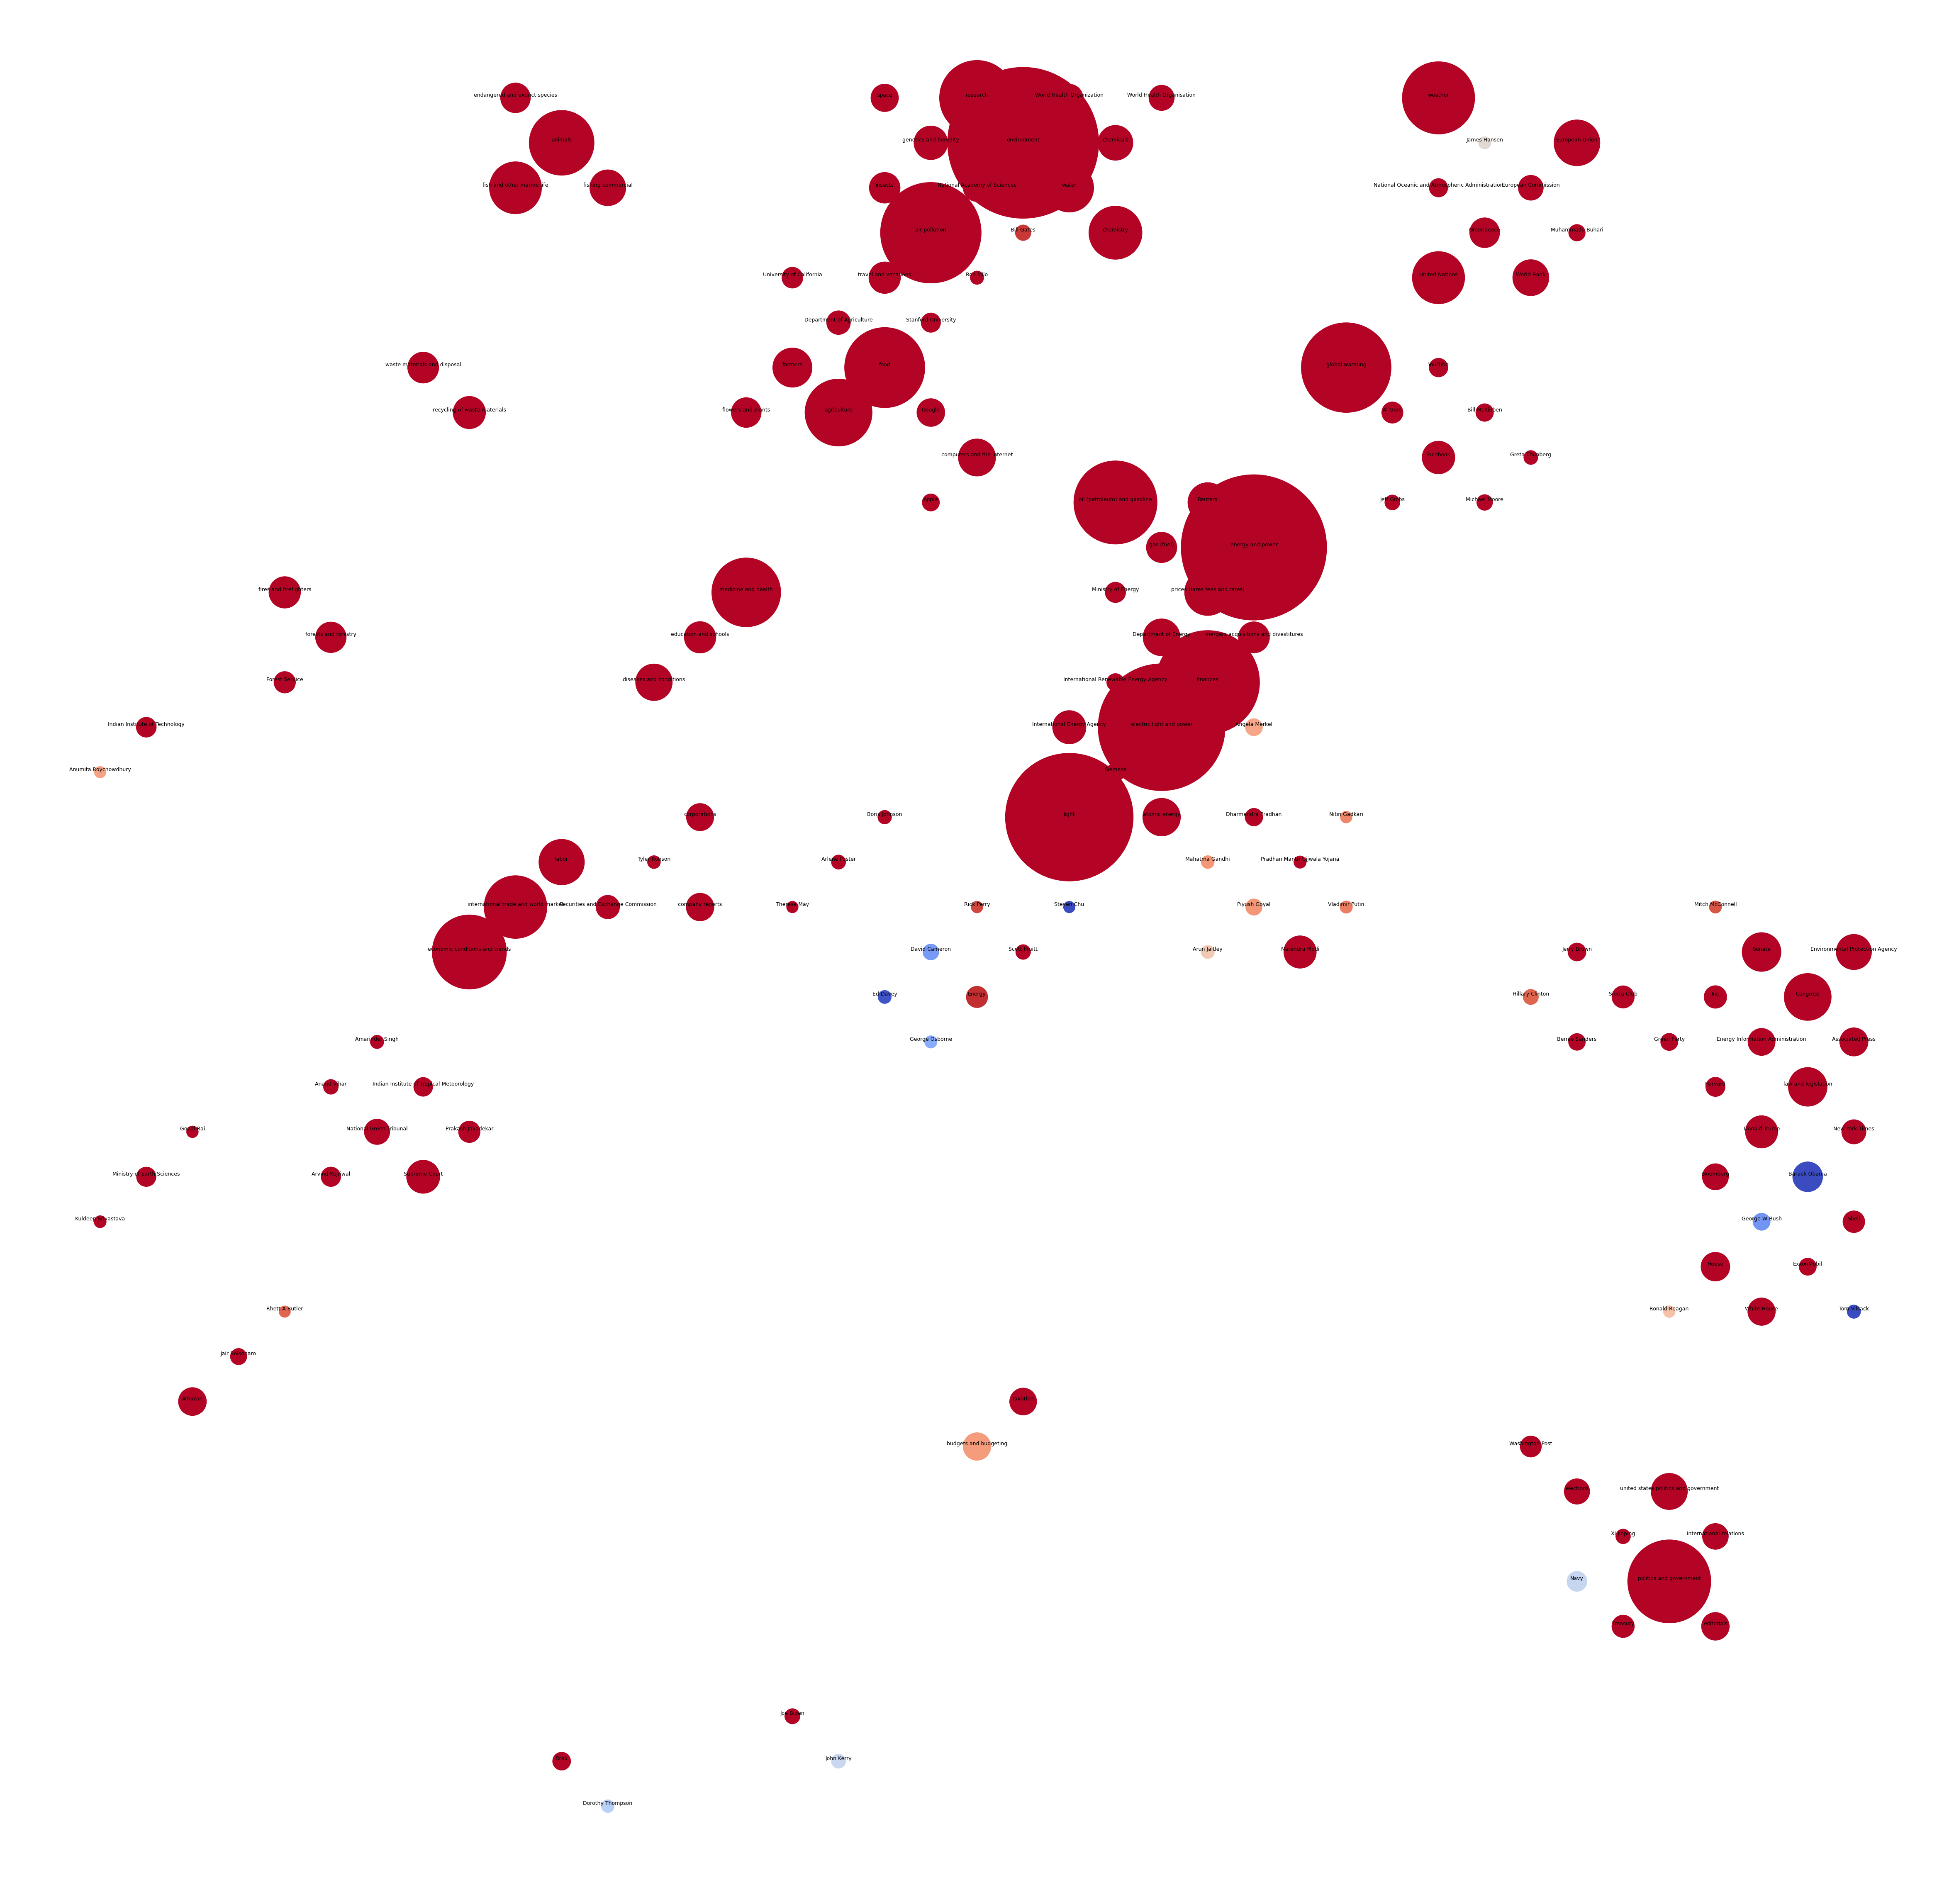

In [19]:
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(entities['x'].to_list(), entities['y'].to_list(), s=entities['frequency'].to_list(), c=entities['color'].to_list())

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row['name'], xy=(row['x'], row['y']), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


# Save

In [20]:
entities.to_csv("src/data/entities.csv", index=False)